In [ ]:
# cell for importing packages for the first time
# import Pkg; Pkg.add("StaticArrays")
# import Pkg; Pkg.add("Revise")


# import Pkg; Pkg.add("@time")
Pkg.add("FastGaussQuadrature")

In [ ]:
ENV["PYTHON"]=""
import Pkg;
Pkg.add("PyCall")

In [ ]:
Pkg.add("PyPlot")

In [1]:
using Plots

using StaticArrays
import LinearAlgebra
import FastGaussQuadrature

push!(LOAD_PATH, pwd())
include("./physconsts.jl")
using .PhysConst


#-------------------------------------- STEP 1 -------------------------------------- #
# define necessary data structures

# module SpaceRadGrid

        
# gaussnodes -   Gauss-Legendre nodes
# gaussweights - Gauss-Legendre weights



using StaticArrays
import Base.@kwdef

    const IX = 1
    const IY = 2
    const IZ = 3

    @show const BIGNUMBER = 1.0E50


    const Rsc =1.0 #PhysConst.KM

    @kwdef struct SGridPar
        

        Nactive = 20;
    
        nghost = 1 #N of ghost cells at every boundary.
            
        Nx = Nactive;   # N of active cells
        Ny = Nactive;
        Nz = Nactive;
        
        Nxtot = Nx +  2*nghost;
        Nytot = Ny +  2*nghost;
        Nztot = Nz +  2*nghost;
    
        is = 1 + nghost; 
        ie = Nxtot -nghost;        

        js = 1 + nghost;  
        je = Nytot - nghost;
        
        ks = 1 + nghost;
        ke = Nztot - nghost;
            
        x1s = -3.0*Rsc
        x1e = 3.0*Rsc
    
        x2s = -3.0*Rsc
        x2e = 3.0*Rsc

        x3s = -1.0*Rsc
        x3e = 1.0*Rsc
        
    end

    @kwdef struct RGridPar
    
        Nfreq = 2 ; # ν - N bins 
    
        NumPhi = 5
        NumTheta = 5
    
        Nang = NumPhi*NumTheta    
        N_fre_ang = Nfreq*Nang  
            

    end




# ------ Init Space and Radiation grids --------------------------------

sg= SGridPar()
rad = RGridPar()


# radiaion matter grid *may be* offset from the space grid boundaries
roffst = 0

is_r = sg.is + roffst
ie_r = sg.ie - roffst 

js_r = sg.js + roffst
je_r = sg.je - roffst 

ks_r = sg.ks + roffst
ke_r = sg.ke - roffst 



# μ = zeros(Float64, rad.NumTheta)     
# @show gaussnodes, gaussweights = FastGaussQuadrature.gausslegendre(rad.NumTheta);
# @show μ .= gaussnodes

# @time nodes, weights = gausslegendre( 100000 );
# 0.007890 seconds (19 allocations: 2.671 MB)




θ = range(0, pi; length = rad.NumTheta)
ϕ   = range(0, 2pi-pi/rad.NumPhi; length = rad.NumPhi)


# ----------------------------------------------------------------------

#                                Grid

x1 = Array{Float64}(undef, sg.Nxtot)
x2 = Array{Float64}(undef, sg.Nytot)
x3 = Array{Float64}(undef, sg.Nztot)

x1b = Array{Float64}(undef, sg.Nxtot)
x2b = Array{Float64}(undef, sg.Nytot)
x3b = Array{Float64}(undef, sg.Nztot)

# ----------------------------------------------------------------------
#                               Gas   



den = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot) 
Tgas = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot) 

OpaCon = zeros(Float64, sg.Nxtot,sg.Nytot,sg.Nztot)


LW =1
UP =2
ndenIon = zeros(Float64, 2, sg.Nxtot,sg.Nytot,sg.Nztot) #2-level ion, cm^-3



# ----------------------------------------------------------------------
#                             Radiation
νRange = Array{Float64}(undef, rad.Nfreq) 

IrPos = zeros(Float64, rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation intensity, forward
IrNeg = zeros(Float64, rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation intensity, backward
Jν = zeros(Float64, rad.Nfreq, sg.Nxtot, sg.Nytot, sg.Nztot); # radiation mean intensity, J
Sν = zeros(Float64, rad.Nfreq, sg.Nxtot, sg.Nytot, sg.Nztot); #S_nu


# reference parameters

# const Tsc = 1.0E5  #a reference gas T, K
# const Dsc=10.0  #a reference gas ndens cm^-3


const lineId=1
# const ν_h1 = 3.29e15



const A_ion = 1 # ion atomic weight
const Nlines = 1
LineList = zeros(Float64, 5, Nlines)

iline =1

NU = 1
GSTAT_L = 2
GSTAT_U = 3
F_ORSC = 4
A_KL = 5
B_KL = 6

# O_VIII 1s-2p
LineList[NU,iline]      = 2.47e15    #nu or cm^-1, or λ
LineList[GSTAT_L,iline] = 2.0   #g_l
LineList[GSTAT_U,iline] = 6.0   #g_u
LineList[F_ORSC,iline]   = 4.16E-1 #f_lu
LineList[A_KL,iline]    = 2.57E12  #A_ki s^-1


# ν_min = 0.1*3.5e15     
# ν_max = 10*νLines[end]     

const NGaussHermNodes = 10

# ----------------------------------------------------------------------

function MakeXYZstagGrid(x1, x2, x3, x1b, x2b, x3b, sg)  #staggered grid

    # add check sizes
    
    xtmp = range(sg.x1s, sg.x1e; length = sg.Nxtot - 2sg.nghost)
    
#     @show sg.is, sg.ie sg.Nx sg.nghost size(xtmp) size(x1) size(sg.is:sg.ie) size(2:2)
    
    x1[sg.is:sg.ie] .= xtmp[:] 
    x1[sg.is-1] = 2*x1[sg.is]- x1[sg.is+1]
    x1[sg.ie+1] = 2*x1[sg.ie] -x1[sg.ie-1]

    xtmp = range(sg.x2s, sg.x2e; length = sg.Nytot - 2sg.nghost)    

    x2[sg.js:sg.je] .= xtmp[:]     
    x2[sg.js-1] = 2*x2[sg.js]- x2[sg.js+1]
    x2[sg.je+1] = 2*x2[sg.je] -x2[sg.je-1]

    xtmp = range(sg.x3s, sg.x3e; length = sg.Nztot - 2sg.nghost)    

    x3[sg.ks:sg.ke] .= xtmp[:]     
    x3[sg.ks-1] = 2*x3[sg.ks]- x3[sg.ks+1]
    x3[sg.ke+1] = 2*x3[sg.ke] -x3[sg.ke-1]
    
    
    x1b[1] = x1[1] - 0.5(x1[sg.is]-x1[1])    
    for i in sg.is:(sg.ie+1)
        x1b[i] = x1[i-1] + 0.5(x1[i]-x1[i-1])
    end

    x2b[1] = x2[1] - 0.5(x2[sg.js]-x2[1])    
    for j in sg.js:(sg.je+1)
        x2b[j] = x2[j-1] + 0.5(x2[j]-x2[j-1])
    end

    x3b[1] = x3[1] - 0.5(x3[sg.ks]-x3[1])    
    for k in sg.ks:(sg.ke+1)
        x3b[k] = x3[k-1] + 0.5(x3[k]-x3[k-1])
    end
    
     
end

mutable struct LongRay
    numOfElm::Int64    
    id::Int64 #id in dir array
    ijkOfCellCrossed :: Matrix{Int64}        
    xyzPos :: Matrix{Float64}
    orig::Int64 #the origin of the ray, as lin index
end



function InitRayDirections(rad::RGridPar, sg::SGridPar)
            
    norm = zeros(Float64, rad.Nang, 3);
    
    m=1
    for (i,ph_i) in enumerate(ϕ)
        for (j,th_j) in enumerate(θ)
            
            μj = cos.(th_j)
            
            sinth_j = sqrt(1-μj^2)
            

            norm[m, IX] = sinth_j *cos(ph_i)    
            
            norm[m, IY] = sinth_j *sin(ph_i)
            
            norm[m, IZ] = μj
#             @show norm[m,:] m            
        m+=1;            
        end
    end

    return(norm)
end

# initialize the angular discretization
norm = InitRayDirections(rad,sg)

    
# initialize the spacial grid    
MakeXYZstagGrid(x1,x2,x3,x1b,x2b,x3b,sg)


@show x3
@show x3b
 

    
NumElemInRayMax = 2*max(sg.Nxtot,sg.Nytot,sg.Nztot)
    
arrOfLongRay = Array{LongRay, 4}(undef, (rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot)); 
    
# @time rayPairArr = Array{RayPair, 4}(undef, (rad.Nang, sg.Nxtot, sg.Nytot, sg.Nztot)); 
     

# *****************************************************************
function PlotRay(ray::LongRay, ax1, ax2)

    
#     @show r0 = [x1[ic],x2[jc],x3[kc]]
#     m = 1
#     @show dir = norm[m,:]
#     ray = arrOfLongRay[m,ic,jc,kc]
#     for i in 1:ray.numOfElm
#         r = ray.xyzPos[:,i]
#     end

    @show y1 = ray.xyzPos[ax2,1:ray.numOfElm]
    @show x1 = ray.xyzPos[ax1,1:ray.numOfElm]
    
    p1 = plot(x1, y1,  seriestype = :scatter)
    p2 = plot!(p1, x1, y1)
        
    display(p2)

    
end 

function xyzToijk(xin::Float64, yin::Float64, zin::Float64)
    i = argmin( abs.(x1 .-xin )); 
    j = argmin(abs.(x2  .-yin)); 
    k = argmin(abs.(x3  .-zin))    
    return(i,j,k)
end

# argmin(νRange,1.0E14)

# *****************************************************************

#   Physics 

function LineDoppWidth(ν0::Float64, i::Int64, j::Int64, k::Int64 )
    @show Te::Float64 = Tgas[i,j,k]
    u0::Float64 = 12.85E+5*(Te/10^4/A_ion)^(1/2)         
    Δν_D::Float64 = u0*ν0/PhysConst.CL    
    
end

function LineDoppWidth(ν0::Float64, Te::Float64)
    u0::Float64 = 12.85E+5*(Te/10^4/A_ion)^(1/2)         
    Δν_D::Float64 = u0*ν0/PhysConst.CL        
end


using .PhysConst: HPL, KBLZ



# SPECTRUM







# function LineProfDop(ν::Float64, ν0::Float64, i::Int64,j::Int64,k::Int64)    
#     Δν::Float64 = LineDoppWidth(ν0,i,j,k)    
#     x::Float64 = (ν-ν0)/Δν    
#     ϕ::Float64 = exp(-x^2)/sqrt(π)
# end


function LineProfDopp(x::Float64)    
    ϕ::Float64 = exp(-x^2)/sqrt(π)
end
function CrossSectionPhotoIonization(ν::Float64) #[cm^2]
    #photo-ionization cross-section

    Z=1.0    
    
    ν0 = 3.29e15
    
    if ν < ν0
        return(0.0)
    else
        
        ν1 = Z^2 * ν0     
        
        A0 = 6.3E-18
    
        y = ν/ν1
        
        ϵ = sqrt(y-1.0) 
    
        f1 = 1/(1.0 - exp(-2.0*pi/ϵ))
        
        e1 = exp(4.0 - 4.0*atan(ϵ)/ϵ)
           
        a = A0/Z^2*y^(-4)*e1*f1
    
        return(a)        
    end
    
end


# function RecombinationCoefficient(ν::Float64, i::Int64, j::Int64, k::Int64)
     
#     @show  n_h = den[i,j,k]  #cm^-3 of H-atoms in ground state    
    
#     @show Te = Tgas[i,j,k]
#     # α1 = 8*Pi*(ν/PhysConst.CL)^2*
    
#     α1::Float64 = 10.0^(-14)   
    
#     a1ν::Float64 = CrossSectionPhotoIonization(ν)
    
# #     @show exp(PhysConst.HPL*(ν_h1-ν)/(PhysConst.KBLZ * Te))
    
#     α1 = 8π*ν^2/PhysConst.CL^2*(PhysConst.HPL^2/(2π*PhysConst.ME*PhysConst.KBLZ * Te))^(3/2)*a1ν 
#     * exp(PhysConst.HPL*(ν_h1-ν)/(PhysConst.KBLZ * Te))

#     @show  a1ν α1 a1ν
    
#     return(α1)
       
# end

# function OpacityRecombination(ν::Float64, i::Int64, j::Int64, k::Int64) #[cm^-1]
    
# # α1 = 8*Pi*(ν/PhysConst.CL)^2*(PhysConst.HPL^2/(2Pi*PhysConst.M))
    
#    @show  n_h = den[i,j,k]  #cm^-3 of H-atoms in ground state    
#     Te = Tgas[i,j,k]
#     Σα = RecombinationCoeffficient(ν,i,j,k)
    
#     κ_h = n_h * Σα
    
#     return(κ_h)
           
# end

# function EmissivityCoeffficient(ν::Float64, i::Int64, j::Int64, k::Int64)
#    #recombintaion emissivity 
# #     Σα
# #     n_e * n_io

#     n_h = den[i,j,k]  #cm^-3 of H-atoms in ground state    
#     Te = Tgas[i,j,k]

    
#     RecombCoef = RecombinationCoefficient(ν,i,j,k)
# #     jν = RecombCoef * /(4π)
    
#     return(jν)
    
# end



# function IonizationFromPhotoEquilibriuum(ν::Float64, i::Int64, j::Int64, k::Int64)

#     Σα = RecombinationCoefficient(ν, i, j, j)
#     n_h = den[i,j,k]
    
#     @show IntJ = Jν[1]*(ν_max-ν_min) #1 approx 
    
#     ξ_h = n_h * Σα/IntJ
        
# end    



    
# begin
#  ν_1 = 0.5*3.5e15
#  ν_2 = 10*ν_1
#  nuvec = range(ν_1,ν_2, length=100);        
#  y =[CrossSecPhotIoniz(ν) for ν in nuvec];
#  y .= y/10^-18
# end
# plot(nuvec, y)

@show Jν[:, is_r, js_r, ks_r]

@show nu = νRange[1]

# @show CrossSectionPhotoIonization(nu)

# @show RecombinationCoefficient(1.0,3,3,3)

# IonizationFromPhotoEquilibriuum(nu, 3, 3, 3)




@show  Δν_D = LineDoppWidth(LineList[1], is_r, ks_r, ks_r)

# LineProfDop(νLines[1], is_r, ks_r, ks_r)
# # integrates f(x) = x^2 from -1 to 1
# @time dot( weights, nodes.^2 )


# needed to integrate over the spec. l. profile



ξi, wi = FastGaussQuadrature.gausshermite(NGaussHermNodes);
@show ξi

@show LinearAlgebra.dot([1.0 for ξl in ξi], wi)/√π


ν_min = 0.5*LineList[NU,iline]
ν_max = 2*ν_min

# InitializeMatter(sg,rad)










const BIGNUMBER = 1.0e50 = 1.0e50
x3 = [-1.1052631578947367, -1.0, -0.8947368421052632, -0.7894736842105263, -0.6842105263157895, -0.5789473684210527, -0.47368421052631576, -0.3684210526315789, -0.2631578947368421, -0.15789473684210525, -0.05263157894736842, 0.05263157894736842, 0.15789473684210525, 0.2631578947368421, 0.3684210526315789, 0.47368421052631576, 0.5789473684210527, 0.6842105263157895, 0.7894736842105263, 0.8947368421052632, 1.0, 1.1052631578947367]
x3b = [-1.157894736842105, -1.0526315789473684, -0.9473684210526316, -0.8421052631578947, -0.736842105263158, -0.631578947368421, -0.5263157894736842, -0.42105263157894735, -0.3157894736842105, -0.21052631578947367, -0.10526315789473684, 0.0, 0.10526315789473684, 0.21052631578947367, 0.3157894736842105, 0.42105263157894735, 0.5263157894736842, 0.631578947368421, 0.736842105263158, 0.8421052631578947, 0.9473684210526316, 1.0526315789473684]
Jν[:, is_r, js_r, ks_r] = [0.0, 0.0]
nu = νRange[1] = 2.3553953427e-314
Te::Float64 = Tga

2.47e15

In [ ]:
@show 10E-10/PhysConst.MP

PhysConst.MSOL/(4/3 *π *PhysConst.RSOL^3)
0.1*PhysConst.MSOL/(4/3 *π *1.0E7^3)

println(   0.4*6.0e14*PhysConst.MP*(x1[end] - x1[1]))

0.4*PhysConst.MP*6.0e14


In [ ]:


@show x2[sg.je] sg.je

argmin(abs.(x2  .- (x2[sg.je])))  



### 

In [ ]:
LineDoppWidth(LineList[1],10E4)
0.4/10^14

In [ ]:
plot(νRange, map(u->Bν(u, Tgas[1,1,1]), νRange), xaxis=:log10, yaxis=:log10)

@show dν_D = LineDoppWidth(LineList[1], Tgas[sg.is,sg.js,sg.ks])

@show nuRangeNonD = (νRange .- LineList[1])/(dν_D)


map(x->LineProfDopp(x), nuRangeNonD)

# plot(x, map((x)->LineProfDop(x), νRange), xaxis=:log10, yaxis=:log10) 
# LineProfDopp()
# import PhysConst, only:HPL








function testBν()
    
    Trange = range(10.0^4, 10.0^5, length= 3)
    
    T=Tgas[1,1,1]
    y =[Bν(nu,T) for nu in νRange]

#     @show -Bν(ν, T)
    
    plot(νRange, y, xaxis=:log, yaxis=:log)

#     for T in Trange
#     #     @show T
#         y =[Bν(nu,T) for nu in νRange]
#         plot!(νRange, y, xaxis=:log, yaxis=:log)
#     end
#     current()

end

DefinePhysModel(sg, rad);

@show Bν(1.0E17, 10.0E5)





In [ ]:
xbi_zip=nothing

 18.880016 seconds (258.40 M allocations: 7.477 GiB, 5.96% gc time)
y1 = ray.xyzPos[ax2, 1:ray.numOfElm] = 

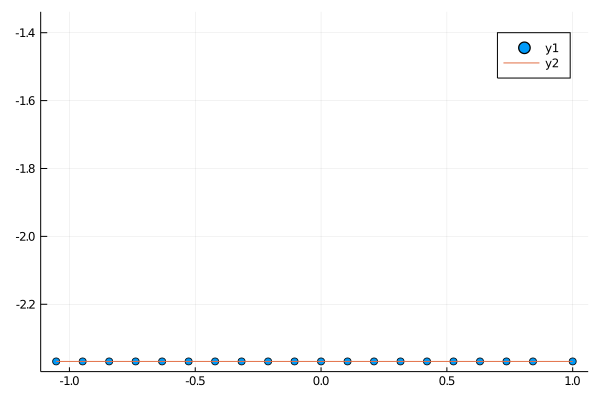

[-2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788, -2.3684210526315788]
x1 = ray.xyzPos[ax1, 1:ray.numOfElm] = [1.0, 0.8421052631578947, 0.736842105263158, 0.631578947368421, 0.5263157894736842, 0.42105263157894735, 0.3157894736842105, 0.21052631578947367, 0.10526315789473684, 0.0, -0.10526315789473684, -0.21052631578947367, -0.3157894736842105, -0.42105263157894735, -0.5263157894736842, -0.631578947368421, -0.736842105263158, -0.8421052631578947, -0.9473684210526316, -1.0526315789473684]


In [2]:
# module RadiationTransfer

x3c = Array{Float64}(undef, 3);
xn = Array{Float64}(undef, 3)

distToNextCell = fill(BIGNUMBER,3) #used in FirstTimeTraceGridOverOneLongRay()
ijk_pos_s = Array{Int64,1}(undef,3)
ijk_pos = Array{Int64}(undef,3)

ijk_max = Array{Int64}(undef,3)
ijk_min = Array{Int64}(undef,3)
ijk_tmp = Array{Int64}(undef,3)

ijk_max .= [ sg.ie+1, sg.je+1, sg.ke+1 ] #max ijk index 
ijk_min .= [ sg.is-1, sg.js-1, sg.ks-1 ] #min index
ijk_tmp .= [0, 0, 0]

# xbi_zip = Array{Array{Float64,1},1}(undef,3)
xbi_zip = [x1b, x2b, x3b]
# @show typeof(xbi_zip)

function CheckForBoundary(xn, ijk_pos, posIndxToUpdate, iter, rbN)

    if iter > 100 
        error("iter too big in CheckForBoundary")
    end

#     @show iter , xn, rbN,x3b[sg.ke]
#         @show iter ,posIndxToUpdate, ijk_pos, ijk_max
    
    
    if LinearAlgebra.norm(xn - rbN)<1.0E-6
#             println(LinearAlgebra.norm(xn - rbN))
        return(true)
    end
    
    if ijk_pos[posIndxToUpdate] == ijk_max[posIndxToUpdate] ||     
        
            ijk_pos[posIndxToUpdate] == ijk_min[posIndxToUpdate] || 
        
           ijk_pos[posIndxToUpdate] == 1 ||                                    
            xn[1] <= x1b[sg.is] || xn[1] >= x1b[sg.ie+1] ||
            xn[2] <= x2b[sg.js] || xn[2] >= x2b[sg.je+1] ||
            xn[3] <= x3b[sg.ks] || xn[3] >= x3b[sg.ke+1]                        
#          println("quit..")
        return(true)
        
    else
        return(false)                
        end      

end

function GiveDistanceToNextCellBoundaryStartB(dir,iter,ijk_pos)
    """ starts from the boundary, passes through ray.head mid-cell, ends at the boundary"""
    
        BrakeOrNot=false
        for (n_it, norm_i ) in enumerate(dir) #QUESTION: maybe iter over pre-calclulated 1/norms
          xc = x3c[n_it] 

             if iter > 1 
             
             if norm_i != 0
               ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])
             else
                ijk_tmp[n_it] = ijk_pos[n_it]
             end 
            
               itmp = ijk_tmp[n_it]
#               @show iter , itmp, ijk_tmp
            
             if itmp == ijk_max[n_it] || itmp == ijk_min[n_it]   
#                 @show iter , itmp, ijk_pos
                BrakeOrNot = true                
                return(BrakeOrNot,BIGNUMBER)
                
             end
             
                xn[n_it] = xbi_zip[n_it][itmp]                                            

             elseif iter==1 #first step from the middle of the cell

                if norm_i>0                                   
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])                    
                elseif norm_i <0                                   
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it]  #belongs to the same index                                
                else                    
                    itmp = ijk_pos[n_it]                                
                end

                xn[n_it] = xbi_zip[n_it][itmp]

             end
                # @show itmp

             if norm_i != 0                      
                               
                distToNextCell[n_it] = abs((xn[n_it] - xc)/dir[n_it])

             else
                distToNextCell[n_it] = BIGNUMBER
             end

            #         println("iter= ",iter," xn=",  xn, " ===> ", "n_it = ",n_it," \n ",
            
            #                 "distToNextCell[",n_it,"]=",distToNextCell[n_it])

        end #for loop over possible directions

        return(BrakeOrNot,distToNextCell)
    end

function TraceGridOverOneLongRay(dir::Vector{Float64}, rayOne::LongRay, 
        sg::SGridPar, ijk_pos, x3c, ijk_orig, rb1, rbN)
    
    """ notes: sometimes icreasing itermax may be necessary;
        x3c is needed as if start is not from cell-center"""
   
#     future: precalc:
    minDistEst = ((x1[sg.ie]-x1[sg.is])^2 + (x2[sg.je]-x2[sg.js])^2 + (x3[sg.ke]-x3[sg.ks])^2)^1/2/(sg.Nxtot^2 + sg.Nytot^2 +sg.Nztot^2)^1/2

    
    dist = 0.0   
    distToNextCell .= BIGNUMBER
    itermax = 3 * sg.Nx 
      
    xn .= x3c
                
    
    if ijk_orig[1]==ijk_pos[1] && ijk_orig[2]==ijk_pos[2] && ijk_orig[3]==ijk_pos[3]

        rayOne.orig = 1
        
#         println(ijk_orig, "  ", ijk_pos)
#         error("ah!")
    end 

    rayOne.numOfElm = 1
    rayOne.ijkOfCellCrossed[:,1] .= ijk_pos
    rayOne.xyzPos[:,1] .= xn
    rayOne.orig = 1 #default 1elem ray
    
    posIndxToUpdate = zeros(Int64,3)

    skip=0  
    
    iter = 2  #2
    
#     for iter in 2:itermax #max length, may be smaller than actual

    while iter <= itermax #max length, may be smaller than actual
        
        BrakeOrNot,distToNextCell = GiveDistanceToNextCellBoundaryStartB(dir,iter,ijk_pos)
        if BrakeOrNot
            break
        end
        
        
#        @show distToNextCell         
#         posIndxToUpdate = argmin( distToNextCell )
        
        if distToNextCell[1] < distToNextCell[2] && distToNextCell[1] < distToNextCell[3]  && distToNextCell[1] > 0
            
                posIndxToUpdate = 1
                ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one
        
        elseif distToNextCell[2] < distToNextCell[1] && distToNextCell[2] < distToNextCell[3] && distToNextCell[2] > 0
            
                posIndxToUpdate = 2            
                ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one
    
        elseif distToNextCell[3] < distToNextCell[1] && distToNextCell[3] < distToNextCell[2]  && distToNextCell[3] > 0   
            
               posIndxToUpdate = 3
            
                ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one
        
        else
            posIndxToUpdate = argmin( distToNextCell )
        end
        
        
#         elseif distToNextCell[1] == 0 && distToNextCell[2] <distToNextCell[3]
#             2
#         elseif distToNextCell[2] == 0 && distToNextCell[1] <distToNextCell[3]
#             1
#         elseif distToNextCell[3] == 0 && distToNextCell[1] <distToNextCell[3]
            
#         elseif distToNextCell[1] == distToNextCell[2] 

#             ijk_pos[1] = ijk_tmp[1]
#             ijk_pos[2] = ijk_tmp[2]
            
#             posIndxToUpdate=1
            
#         elseif distToNextCell[1] == distToNextCell[3]

#             ijk_pos[1] = ijk_tmp[3]
#             ijk_pos[3] = ijk_tmp[3]

#             posIndxToUpdate= 1 

#         elseif distToNextCell[2] == distToNextCell[3]

#             ijk_pos[2] = ijk_tmp[2]
#             ijk_pos[3] = ijk_tmp[3]            
#             posIndxToUpdate= 2
                       
#         else
#             error("unknown case")
        
#         end
                                
        
        dist = distToNextCell[posIndxToUpdate]
        ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] 
        
        
        xn .= x3c .+ dir*dist   
        x3c .= xn
        
        if dist > minDistEst                           
            
            #update rayOne
            rayOne.numOfElm = iter
            
            rayOne.ijkOfCellCrossed[:,iter] .= ijk_pos
            
#             @show rayOne.xyzPos[:,iter-1], rayOne.xyzPos[:,iter] ,xn
            
            rayOne.xyzPos[:,iter] .= xn
            
#             @show iter, rayOne.xyzPos[:,iter-1], rayOne.xyzPos[:,iter],rayOne.xyzPos[:,iter+1]
                    
            if ijk_orig[1]==ijk_pos[1] && ijk_orig[2]==ijk_pos[2] && ijk_orig[3]==ijk_pos[3]
                
                rayOne.orig = iter
                
    #             error("ah!")
            end 
            
            testToBreak=CheckForBoundary(xn,ijk_pos,posIndxToUpdate,iter,rbN) 
            
            if testToBreak
    #             @show (xn,rbN); 
#                 @show test
                break                        
            end       
      
            #check equal points
            
             if iter>1
                dx_i = LinearAlgebra.norm(rayOne.xyzPos[:,iter].-rayOne.xyzPos[:,iter-1])        

                if dx_i < 1E-10
                    @show "!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!"            
                    @show iter
                    
                    @show rayOne.id,dist
                    @show rayOne.xyzPos[:,iter]
                    @show rayOne.xyzPos[:,iter-1]
                    @show dir            
                    @show distToNextCell,posIndxToUpdate
                    PlotRay(rayOne, 1, 3);
                    error("attn: dx_i=0")
                end
              end
            
            iter+=1
            
            
        else
            skip+=1 
#             @show "skip", skip
            
        end #dist>0
        
                    
        
        if iter==itermax
            PlotRay(rayOne, 1, 3)
        
            for i=1:rayOne.numOfElm 
                println("𝐫=",rayOne.xyzPos[:,i],";  ", "\bfi =",  rayOne.ijkOfCellCrossed[:,i],  "\n")

            end
          error("iter==itermax")
        end
  
  
  
  
        
    end #over ray

end 


# xbc = [ [x1b[sg.is], x1b[sg.ie]] [x2b[sg.js], x2b[sg.je]] [x3b[sg.ks], x3b[sg.ke]]]
xbc = [ [x1[sg.is], x1[sg.ie]] [x2[sg.js], x2[sg.je]] [x3[sg.ks], x3[sg.ke]]]


ijk_pos_head = [0,0,0]

# display(xbc)

function GetIntersectionXYZWithBoundary(dir,ijk_p)

    rbc = [0.0, 0.0 , 0.0]
    
#     display(rbc)
    
    Dist123 = [0.0, 0.0, 0.0]; 
    
        x3c .= [ x1[ijk_p[IX]], x2[ijk_p[IY]], x3[ijk_p[IZ]] ]
            
        for (i_123, norm_i ) in enumerate(dir)

            if norm_i != 0.0
                l1 = max(( xbc[1,i_123] .- x3c[i_123] )/norm_i,0.0)
                l2 = max(( xbc[2,i_123] .- x3c[i_123] )/norm_i,0.0)
                Dist123[i_123] = max(l1,l2)            

            else
                Dist123[i_123] = BIGNUMBER
            end

        end
        
        recId = argmin(Dist123)
    
 
        rbc .= x3c .+ dir * Dist123[recId]                
  
        i,j,k = xyzToijk(rbc[1],rbc[2],rbc[3])
    
#         @show rbc, x1[i], x2[j],x3[k]
    
#         ijk_pos[n_it] + copysign(1, dir[n_it])
    
    return(rbc, i,j,k)
end


# dir= norm[4,:]
# @show dir rbc = GetIntersectionXYZWithBoundary(dir,[5,5,5])   



maxNumElemInRay = 0

function GivAllGridArrOfLongRays()

# @time begin
    
is = is_r; ie = ie_r
js = js_r; je = je_r 
ks = ks_r; ke = ke_r     

    
posInRay=1
Nr=100    
    
    testRay = LongRay(Nr,1, Array{Int64}(undef,3,Nr),Array{Float64}(undef,3,Nr),posInRay) 
    

    # TRACE GRID AND ALLOCATE RAY ARRAY
    
# ks=ke=1; js=je=1; is=ie=1            
    
    for k=ks:ke        
        for j=js:je        
            for i=is:ie    
  
                  ijk_pos_head.= [i,j,k]  #remember your origin
                

                    for m=1:rad.Nang
                    
                      dir = norm[m,:]                            
                    
                     ijk_pos .= ijk_pos_head


                                        
                    rbN,ib,jb,kb = GetIntersectionXYZWithBoundary(dir, ijk_pos);                        
                    rb1,ib,jb,kb = GetIntersectionXYZWithBoundary(-dir, ijk_pos);     

                    
                     ijk_pos .= ijk_pos_s .= [ib, jb, kb]                                                                                  
                     x3c .= rb1 
                    
                    TraceGridOverOneLongRay(dir, testRay, sg, ijk_pos, x3c, ijk_pos_head, rb1, rbN) 

                 
                    
#                      error("stop")
                    # @show rb1, testRay.xyzPos[:,1], rbN, testRay.xyzPos[:,testRay.numOfElm] ; error()                    
                    
                    
                    Ntot = testRay.numOfElm                    
                    
                    global maxNumElemInRay = max(maxNumElemInRay, Ntot) 
                    
#                     if Ntot ==1
#                         @show dir, ijk_pos, ijk_pos_head 
#                         @show x3c, rb1, rbN 
#                         @show x1[ijk_pos[1]]                        
#                         error("stop")
#                     end

                    arrOfLongRay[m,i,j,k] = LongRay(Ntot, m,            
                        zeros(Int64,3,Ntot), zeros(Float64,3,Ntot), testRay.orig)
                  
#                     arrOfLongRay[m,i,j,k] = LongRay(Ntot, m,            
#                         Array{Int64}(undef,3,Ntot), Array{Float64}(undef,3,Ntot), testRay.orig)
                    
                    arrOfLongRay[m,i,j,k].id

                    for iter = 1:Ntot
                                                
                        arrOfLongRay[m,i,j,k].ijkOfCellCrossed[:,iter] = testRay.ijkOfCellCrossed[:,iter] 
                        
                        arrOfLongRay[m,i,j,k].xyzPos[:,iter] = testRay.xyzPos[:,iter]                                    
                        
                    end                       

                    
#                     let
#                        for i in 1:ray.numOfElm-1
#                             Nmat = ray.numOfElm                
#                             dx_i = zeros(Float64, Nmat)
#                             @show dx_i[i] = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i]) 
#             #                 display(plot(1:Nmat, dx_i))
#                        end            
#                     end                    
                    
                    
                    
                    
                    
#                      
#                     error("ha")
                    
                end                       
        end        
    end    
end
    testRay=nothing
    "done"
    
end


@time GivAllGridArrOfLongRays()

let
    ray = arrOfLongRay[rand(1:rad.Nang),3,4,10]
    PlotRay(ray, 3, 2)
end

In [ ]:
function testFirstTimeTraceGridOverOneLongRay(rad::RGridPar, sg::SGridPar, swch)
    rayid = rand(1:rad.Nang)
    

    @show dir = norm[rayid,:]
    posInRay = 1 #
    
    if swch=="LongRay"
        testRay = LongRay(NumElemInRayMax, rayid,          
            Array{Int64}(undef,3,NumElemInRayMax),
            Array{Float64}(undef,3,NumElemInRayMax), posInRay )       
    else
        error("swch is not supported")
    end

    
    numTests=1
    for n = 1:numTests
        println( " test :", n )
        
        ijk_pos_s[:] = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))]; 

        ijk_pos_s[:] = [rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ]    
        
        ijk_pos .= ijk_pos_s

        ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]                
     
#         x3c .= [ x1[ip], x2[jp], x3[kp] ]
        
        xyz_s = [ x1[ip], x2[jp], x3[kp] ]


        FirstTimeTraceGridOverOneLongRay(dir, testRay, sg, ijk_pos)     
        
      
        
        rprev= zeros(Float64,3)
        
#         @show testRay.numOfElm
        
        if testRay.numOfElm > 0
            rprev = xyz_s
            for i=1:testRay.numOfElm
                  
                ds=LinearAlgebra.norm(testRay.xyzPos[:,i] .- rprev)

                rprev .= testRay.xyzPos[:,i]
                
#                 @show i,ds
            end
            
                   
            xyz_e = testRay.xyzPos[:,testRay.numOfElm]                
            dist = LinearAlgebra.norm( xyz_e .- xyz_s)     


            xyz_0e = xyz_s + dir*dist

            Δ = LinearAlgebra.norm( xyz_e[:].-xyz_0e[:])/
                    LinearAlgebra.norm( xyz_0e[:])


            println("|| rend - rs ||/||rs|| = ",  Δ)    
            if Δ <= 1e-5
                println(" Test Passed ! ")    
            else
                println("𝐧 = ",  dir)                
                println(" xyz_e= ",  xyz_e)                
                println(" xyz_s= ",  xyz_s)                
                println(" xyz_0e= ",  xyz_0e)                    
                println(" dist=", dist)      
                error("Test Failed !")
            end

            
        end
            

        
    end
end

function test_and_plot_ray(rad, sg)
    rayid = 2
    rayid = rand(1:rad.Nang)
    posInRay = 1 #
    x0=0. 
    y0=0. 
    z0=-2.
    
    @show dir = norm[rayid,:]
#     dir = norm[rayid, :] = [-0.6300367553350504, -0.32101976096010315, 0.7071067811865476]
    
    ax1= 1
    ax2 = 2
    ax3 = 3
    
        
    ray = LongRay(NumElemInRayMax, rayid,          
            Array{Int64}(undef,3,NumElemInRayMax), Array{Float64}(undef,3,NumElemInRayMax),posInRay )       

    
    ic,jc,kc=xyzToijk(x0, y0, z0)                    
    ijk_pos .= ijk_pos_s.=[ic,jc,kc]

    
    @show  ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]                
                     
    xyz_s = [ x1[ip], x2[jp], x3[kp] ]

    FirstTimeTraceGridOverOneLongRay(dir, ray, sg, ijk_pos)     

    
    @show ray.xyzPos[ax2,:] ray.numOfElm
  
    PlotRay(ray, ax2, ax3)
    
end



testFirstTimeTraceGridOverOneLongRay(rad, sg, "LongRay")

test_and_plot_ray(rad, sg)

In [ ]:
not ready must convert to 𝐧!

function thPhToLocalDirVectIndex(th_in::Float64, phi_in::Float64)
#     """ converts θ, ϕ into index in the dirrectional vector 𝐧 """
    t = argmin(abs.(θ  .-th_in)); 
    f = argmin( abs.(ϕ .- phi_in ));    
    
    return(t,f)
end

thPhToLocalDirVectIndex(0.0, 0.0)

In [ ]:
function test3()
    rayid = rand(1:rad.Nang)

    x0=0. 
    y0=0. 
    z0=0.
      
    ax1= 1
    ax2 = 2
    ax3 = 3
    
    @show dir = norm[rayid,:]
    
    ic,jc,kc = xyzToijk(x0, y0, z0)                    


    ray =  arrOfLongRay[rayid, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]
    
    
    @show ray.xyzPos[3,:]
    
    PlotRay(ray, ax1, ax3)
    
end
test3()

<h1>
<b>
Numerical
</b>
</h1>

$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  


<b> Matrix  </b> eq: 
$$
-A_i u_{i-1} + B_i u_{i} -C_i u_{i+1} = S_i
$$

Coefficients have a slightly different form compared to <b>RH91</b> for a slightly better representation of 
the numerical derivative on a staggered grid. The source term allows for implicit contribution from the $b_m u_m$ from $S$. 
 
 $$
 y_i \left(-b_m
    +\frac{p}{\delta \tau _i}
    \left(\frac{1}{\delta \tau _{i+\frac{1}{2}}}+\frac{1}{\delta \tau
   _{i-\frac{1}{2}}}\right)
   +1\right)
   -\frac{p y_{i-1}}{\delta \tau _{i-\frac{1}{2}} \delta \tau _i}
   -\frac{p y_{i+1}}{\delta \tau _i \delta \tau _{i+\frac{1}{2}}}-S_i-S_\beta=0
 $$

Boundary conditions:
    
 $$
 \text{at}\quad t = \tau_1\simeq 0: \quad \alpha \, u'(t) + \beta \, u(t) = \gamma \mbox{,} 
 $$
 
 $$
 v(\tau=0)=u(\tau=0)\mbox{,}
 $$
    
 $$
 \text{at}\quad t = \tau_N: \quad \alpha_1 \, u'(t) + \beta_1 \, u(t) = \gamma_1 \mbox{.} 
 $$


 $$
    i=1:\qquad y_1 \left(-\frac{\alpha}{\delta \tau _{\frac{3}{2}}}+\beta\right)+\frac{\alpha}{\delta \tau _{\frac{3}{2}}} y_2=\gamma
 $$
 
 $$
 i=N:\qquad
  -\frac{\alpha_1 }{\delta \tau _{N-\frac{1}{2}} }y_{N-1} +y_N \left(\frac{\alpha_1}{\delta \tau _{N-\frac{1}{2}} }+\beta_1\right)=\gamma_1
$$
 
<h>
    <b> Source function: </b>   
</h>
$$ 
S_{i}=\alpha\,\Sigma_{n}^{N_{\nu}}a_{n}\phi_{in}\,\Sigma_{m=1}^{N_{m}}b_{m}u_{imn}
$$ 
    

<h1> Coeffs and Source Function </h1>

$$   
 \begin{equation}    
    p\frac{d^2u}{dt^2} = u - S\mbox{,}
 \end{equation}
$$  

$$
p=\frac{1}{(\chi_\nu + \sigma_\nu)^2}
$$

<h1> $\Lambda$ operator within the Feautrier method </h1>

$$
\begin{equation}    
 {\bf T}\cdot {\bf u} = 
\end{equation}
$$


<!-- $$
a_1 = \Sigma(R_{lj} + C_{lj}) + C_{lu},
$$
$$
a_2 = \Sigma n_j(R_{jl} + C_{ji}),
$$

$$
a_3 = \Sigma (R_{uj} + C_{uj}) + C_{ul}
$$

$$ 
a_4 = \Sigma nj(R_{ju} + C_{ju})
$$ -->

In [19]:

using .PhysConst: MP,ME,QE,CL,KPE,KM


function Bν(ν::Float64,T::Float64)
    Bnu = 2.0*PhysConst.HPL* ν^3/(PhysConst.CL^2)/
        (exp(PhysConst.HPL*ν/PhysConst.KBLZ/T)-1.) 

    Bnu = 1.  
    
  return (Bnu )
    
end
function InitializeRadiationFunctions(ν_min, ν_max, wtodo, rad::RGridPar)
    
    if wtodo=="BB"  
        
        ν_1 = ν_min
        
        ν_2 = rad.Nfreq>1 ? ν_max : ν_1
        
        @show νRange  .= range(ν_1,ν_2, length=rad.Nfreq)        

        is = is_r; ie = ie_r    
        js = js_r; je = je_r 
        ks = ks_r; ke = ke_r         

        
        for k=sg.ks:sg.ke
            for j=sg.js:sg.je        
                for i=sg.is:sg.ie                   
                  for f=1:rad.Nfreq
                        
                        νi = νRange[f]                        
                        
                        Jν[f,i,j,k] = 1.0*Bν(νi,Tgas[i,j,k])
                        
                        Sν[f,i,j,k] = Bν(νi,Tgas[i,j,k])
                        
                        
                   end
                end
            end
        end
                                                        

    else        
        error("undefined in DefineSpectrum")    
    end 
    
end

InitializeRadiationFunctions(ν_min,ν_max,"BB", rad)

function InitializeMatter(sg::SGridPar, rad::RGridPar)   
    
#     KM=1.0E5

#     x1 .*= KM; x2 .*= KM; x3 .*= KM;
#     x1b .*= KM; x2b .*=KM; x3b .*= KM;

    
    Tgas .= 1.0e5      
    den .=  6.0e14  # cm^-3 of nH + nH0    

    den .=  6.0e20  
    
   slab_height = 0.5*( x3[end] - x3[1]  )
    

    hp = PhysConst.HPL
    kb = PhysConst.KBLZ
    
    for k=sg.ks-1:sg.ke+1    
        for j=sg.js-1:sg.je+1                
            for i=sg.is-1:sg.ie+1                   
                
               ndenIon[LW,i,j,k] = 0.5*den[i,j,k]  
                
#                ndenIon[UP,i,j,k] = exp(-LineList[NU,lineId]*hp/kb/Tgas[i,j,k]) *LineList[GSTAT_U,lineId]/LineList[GSTAT_L,lineId]

                ndenIon[UP,i,j,k] = 0.1ndenIon[LW,i,j,k] 
#              @show ndenIon[LW,i,j,k], ndenIon[UP,i,j,k]
                
                if x3[k] > (x3[sg.ks] + slab_height )
                    
#                     Tgas[i,j,k] = x3[k] > (x3[sg.ks] + slab_height ) ? 1000.0 : Tgas[i,j,k]
                    
#                     Tgas[i,j,k] = 1000.0
                    
#                     @show Tgas[i,j,k], i,j,k
                    
                end
            end
        end
    end
     
    
#     plt = plot(  , y   )             
#     den .= 1.0E18                


end


function Get_χ_ul(ν::Float64, i::Int64, j::Int64, k::Int64)
#     i -lower
#     j - upper
    
    Δν_D=LineDoppWidth(LineList[NU,lineId], Tgas[i,j,k])
    
    ϕ_x = 1.0    
    ϕ_ν = ϕ_x/Δν_D
        
    χ = π *QE^2/ME/CL * LineList[F_ORSC,lineId]*
    (ndenIon[LW,i,j,k] - LineList[GSTAT_L,lineId]*ndenIon[UP,i,j,k]/LineList[GSTAT_U,lineId])*ϕ_ν

    #     @show ndenIon[UP,i,j,k],ndenIon[LW,i,j,k]LineList[GSTAT_L,lineId],LineList[GSTAT_U,lineId], QE, CL, ME, Δν_D,ϕ_ν,χ

    if χ<0
        error("χ<0 in Get_χ_ul")        
    end
    
#     χ=0.4*6.0e14*PhysConst.MP

    if χ<1E-5
        @show "::::",LineList[F_ORSC,lineId], ndenIon[LW,i,j,k],i,j,k
    end
    
    χ = KPE*den[i,j,k]*MP
    
    χ *= Rsc    #non-dimensional  ̃χ ≡ R_sc χ
    

#     χ= abs(x3[k]-0.0)<0.3 ? 15.0 : 0

    χ= 15.0

    return (χ)
    
    
end

function UpdateOpacityOnXYZGrid(sg::SGridPar)
     
    for k=1:sg.Nztot
        for j=1:sg.Nytot      
            for i=1:sg.Nxtot
                
            OpaCon[i,j,k]= 0.0

            end
        end
    end  
            
end

function Giv_ϵ_th(lineId::Int64,i::Int64, j::Int64, k::Int64)
    """
    Sf = (1.0-ϵ_th)*Jbar + ϵ_th*Bp    
    """
    
    Te::Float64 =  Tgas[i,j,k]
    
    C_ul :: Float64 = 0.1
    A_ul :: Float64 = 0.1
    
    ν ::Float64 = LineList[NU,lineId]
    
    y::Float64 = PhysConst.HPL*ν/PhysConst.KBLZ/Te
    
    expon::Float64 = exp(-y)
    
    ϵ1::Float64 = C_ul*(1.0 - expon)/A_ul    
    
    ϵ::Float64 = ϵ1/(1.0+ϵ1)    
    
    ϵ =0.5
    
    return(ϵ)
end

function SrcFun(ν::Float64, i::Int64,j::Int64,k::Int64)

#     T =  Tgas[i,j,k]
    
    Sf::Float64  = 0.0;
    
    j_ν::Float64 = EmissivityCoeffficient(ν,i,j,k)
    κ_ν::Float64 = OpacityRecombination(ν,i,j,k)
    
    # Sf = Bν(ν, T)

    Sf = j_ν/κ_ν
    
    return(Sf)
        
end

    
function SrcFun2lev(ν::Float64, i::Int64, j::Int64, k::Int64) # 2 level atom 

    # ϵ::Float64, lineId::Int64, u::Float64, 
    
    Te::Float64 =  Tgas[i,j,k]
            
    Sf::Float64 = 0.0 #2.0PhysConst.HPL*ν^3/PhysConst.CL^2/((n_l*g_u/n_u/g_l)-1.0) 
            
    Bp::Float64 = Bν(ν,Te) 
    
    ϵ_th =  Giv_ϵ_th(lineId, i,j,k)
    
    Jbar = Jν[lineId, i,j,k]
    
    Sf = (1.0-ϵ_th)*Jbar + ϵ_th*Bp
    
#     @show Sf    
   
#     if x3[k] > (x3[sg.ks] + 0.5 )
#         Sf = 0*((1.0-ϵ_th)*Jbar + ϵ_th*Bp)
#     else
#         Sf = (1.0-ϵ_th)*Jbar + ϵ_th*Bp
# #         Sf*=0.0
#     end
    
    Sf = exp( -(x3[k])^2/0.1 )

    
    Sf = abs(x3[k]-0.0)<0.3 ? (1.0-ϵ_th)*Jbar + ϵ_th*Bp : 0.0 
       
    Sf = (1.0-ϵ_th)*Jbar + ϵ_th*Bp

    Sf = Bp
    return(Sf)
        
end

InitializeMatter(sg, rad)  

# GetSourceFuncParams(1, 1,1,1,)

Get_χ_ul(LineList[NU,lineId], sg.is, sg.js, sg.ks)

SrcFun2lev(LineList[NU,lineId],rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r))



νRange .= range(ν_1, ν_2, length = rad.Nfreq) = [1.235e15, 2.47e15]


1.0

νRange .= range(ν_1, ν_2, length = rad.Nfreq) = [1.235e15, 2.47e15]
ijk_pos = 

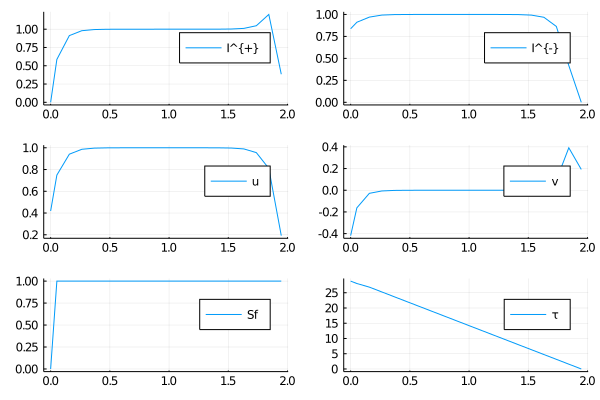

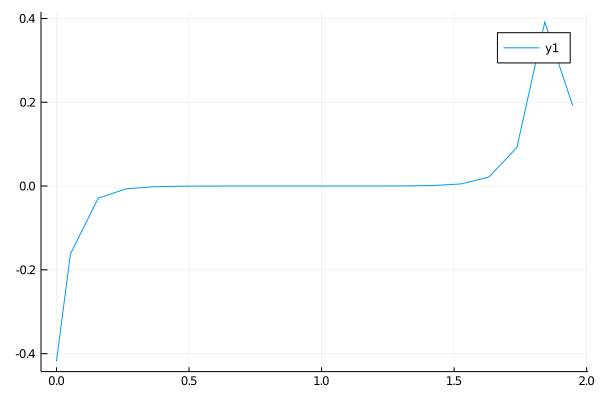

[11, 11, 11]
(A[1], B[1], C[1], Z[1], S[1]) = (0.0, -34.00000000000002, -19.00000000000002, -0.0, 0.0)
(i, ":") = (2, ":")
(A[i], B[i], C[i], S[i]) = (240.66666666666686, 586.0, 120.33333333333317, 225.0)
(i, H[i], F[i], Z[i]) = (2, 224.99999999999997, 2.7521590353592997, 0.4983280496808096)
(i, ":") = (3, ":")
(A[i], B[i], C[i], S[i]) = (90.24999999999991, 405.5, 90.2500000000001, 225.0)
(i, H[i], F[i], Z[i]) = (3, 225.0, 3.2265615686366935, 0.7077627507244549)
(i, ":") = (4, ":")
(A[i], B[i], C[i], S[i]) = (90.2500000000001, 405.5, 90.24999999999991, 225.0)
(i, H[i], F[i], Z[i]) = (4, 224.99999999999997, 3.256475849164241, 0.7519924125956713)
(i, ":") = (5, ":")
(A[i], B[i], C[i], S[i]) = (90.24999999999987, 405.4999999999999, 90.24999999999996, 225.0)
(i, H[i], F[i], Z[i]) = (5, 225.00000000000006, 3.2581386536547643, 0.7620858475461325)
(i, ":") = (6, ":")
(A[i], B[i], C[i], S[i]) = (90.25000000000001, 405.5, 90.25000000000001, 225.0)
(i, H[i], F[i], Z[i]) = (6, 225.0, 3.2582303962

In [20]:
# ijk_start_end = zeros(Float64,3,2)

# @show ijk_start_end = [[is_r, ie_r] [js_r,je_r] [ks_r,ke_r]]
ijk_start_end = [[sg.is, sg.ie] [sg.js,sg.je] [sg.ks,sg.ke]]
# 

bndNorm = zeros(Float64,6,3)

bndNorm[1,:] .= [-1,0,0]
bndNorm[2,:] .= [1,0,0]
bndNorm[3,:] .= [0,-1,0]
bndNorm[4,:] .= [0,1,0]
bndNorm[5,:] .= [0,0,-1]
bndNorm[6,:] .= [0,0,1]


ijk_bc = zeros(Float64,3)        



function GiveIrradiationIntensity()
 Iirrad = 0.0
end

function Give_BC_β(bndryIndexOnRay, χ, ray::LongRay, i::Int64, j::Int64, k::Int64)    
    
#     i0 = ray.numOfElm
    
#     @show ijk_ray_bc = [ray.ijkOfCellCrossed[1,i0],ray.ijkOfCellCrossed[2,i0],ray.ijkOfCellCrossed[3,i0]] 
#     @show i j k   
    
    rayDir = norm[ray.id,:]    
    gam ::Float64=0.0
    bet ::Float64=0.0
        
#     @show ray.xyzPos[3,bndryIndexOnRay], bndryIndexOnRay, x3[ks_r]
#     error("Ah!")        
#     if ray.xyzPos[3,bndryIndexOnRay] <= x3[ks_r]                
              
                r = rayDir[3]*bndNorm[5,3]
# error("Ah!")
#                 if r<0 #back of the ray

        if bndryIndexOnRay == ray.numOfElm
    
                 Iplus = GiveIrradiationIntensity()
                  
                 bet = χ
                 
#                  @show bndryIndexOnRay, bet, χ
        
                  gam = -χ*Iplus
                    
#                 elseif r>0 #face of the ray

        elseif bndryIndexOnRay == 1
        
#             error()
            #irradiation can be I^+ or. I^-
            
                  Iminus = GiveIrradiationIntensity()
            
                  bet = -χ
            
                  gam = χ*Iminus
        
#                   @show ray.xyzPos[3,bndryIndexOnRay], bndryIndexOnRay, x3[ks_r];error("Ah!")
        
                else
                  error("case not knowm in Give_BC_β:
                    ", rayDir, "\n", bndNorm[5,:])
                end
#     end
        
# @show bndryIndexOnRay, bet
    return(gam,bet)
    
end                    



function ProgRayBC_1(ν::Float64, χ::Float64, ray::LongRay,i::Int64, j::Int64, k::Int64)
    is = is_r; ie = ie_r    
    js = js_r; je = je_r 
    ks = ks_r; ke = ke_r         

    
    gam1,bet1 = Give_BC_β(1, χ, ray, i,j,k) 
    
    alph1 = 1.0 
    
    
    
#      alph1,bet1,gam1 = 0.0, 1.0 ,1.0
        
    return(alph1, bet1, gam1)
    
end


function ProgRayBC_N(ν::Float64, χ::Float64, ray::LongRay, i::Int64,j::Int64,k::Int64)
    
    gamN,betN = Give_BC_β(ray.numOfElm, χ, ray, i,j,k)
    
    alphN = 1.
    
    alphN, betN, gamN = 0.0, 1.0, 4.0

#     gamN = 0.
#     @show alphN,betN,gamN
    
    return(alphN,betN,gamN)
    
end

# function ProgRay_pCoef(ν::Float64, χ::Float64, i::Int64,j::Int64,k::Int64)
    
#     p::Float64 = 1/χ^2

#     return(p)
# end    

# let
# @show χ1 = Get_χ_ul(LineList[NU,lineId],sg.is, sg.js, sg.ks)
# @show ProgRayBC_1(LineList[NU,lineId], χ1, sg.is, sg.js, sg.ks,
# arrOfLongRay[m,3,3,3].dir)    
# @show ProgRayBC_N(LineList[NU,lineId], χ1, sg.is, sg.js, sg.ks)
# @show ProgRay_pCoef(LineList[NU,lineId],χ1, sg.is, sg.js, sg.ks)
# end




λii_mu = zeros(Float64,rad.Nang)

χ_OnRay = zeros(Float64,maxNumElemInRay) #precalculated χ_line, on a ray

Ipos = zeros(Float64,maxNumElemInRay) 
Ineg = zeros(Float64,maxNumElemInRay) 


Sf_ray = zeros(Float64,maxNumElemInRay)



function ProgonRybHumAlongTheRay(ν::Float64, ray::LongRay, sg::SGridPar, rad::RGridPar)

    Nmat = ray.numOfElm
    
    u = zeros(Float64, Nmat)
    v = zeros(Float64, Nmat)
    λii  = zeros(Float64, Nmat)
        
    dx_i = zeros(Float64, Nmat)

    τn = zeros(Float64, Nmat)
    
    
    A = zeros(Float64, Nmat)
    B = zeros(Float64, Nmat)    
    C = zeros(Float64, Nmat)
    D = zeros(Float64, Nmat)
    Z = zeros(Float64, Nmat)
    S = zeros(Float64, Nmat) #Rhs


    Sbet =0.
    bm = 0
    

    ic,jc,kc = ray.ijkOfCellCrossed[1,1],ray.ijkOfCellCrossed[2,1],ray.ijkOfCellCrossed[3,1]    
    
    χ_OnRay[1] = Get_χ_ul(ν,ic,jc,kc)
    alph,bet,gam = ProgRayBC_1(ν,χ_OnRay[1], ray, ic,jc,kc)    
      
#     @show "passin"  
#     @show ray.numOfElm
#     @show ray.xyzPos[:,2],ray.xyzPos[:,1]
    
    dx_i1 = LinearAlgebra.norm(ray.xyzPos[:,2].-ray.xyzPos[:,1])      
#     @show "passout"
    
    dx_i[1] = dx_i1         
    dx_ip05 = dx_i[1]
    
        
#     p = ProgRay_pCoef(ν,χ_OnRay[1], ic,jc,kc)
            
    A[1] = 0.    
    B[1] = (bet - alph/dx_ip05)    
    C[1] = (-alph/dx_ip05)        
    S[1] = (gam)    

            
    D[1] = C[1]/B[1]
    Z[1] = S[1]/B[1]
    
    C[Nmat]=0.
     
    if isnan(D[1]) || B[1] ==0
        error("atten")
    end

#     @show A[1],B[1],C[1],Z[1] S[1]                            
    
    
    for i = 2 : Nmat-1 #forward            
        
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
                        
         χ_OnRay[i] = Get_χ_ul(ν,ic,jc,kc)
                
        
#         dx_i[i] = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])
        
        dx_im05 = LinearAlgebra.norm(ray.xyzPos[:,i].-ray.xyzPos[:,i-1]) 
        dx_ip05 = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i]) 
        dx_i[i] = 0.5*(dx_im05+dx_ip05)
        
        if dx_i[i]==0            
            @show "warn: " Nmat, i, ic, jc, kc, ray.xyzPos[:,i+1], ray.xyzPos[:,i]            
            error("dx=0 in ProgonRybHumAlongTheRay")            
        end
                
#        dx_im05 = dx_i[i]       
#        dx_ip05 = dx_i[i]  

#      p = ProgRay_pCoef(ν,χ_OnRay[i], ic,jc,kc)
        
       Sd = SrcFun2lev(ν, ic,jc,kc)

       S[i] = χ_OnRay[i]^2*(Sd + Sbet)
                    
       A[i] = 1.0 /(dx_i[i]*dx_im05)
        
       B[i] = (1. - bm)*χ_OnRay[i]^2 + ((1/dx_im05 + 1/dx_ip05))/dx_i[i]
        
       C[i] = 1.0/(dx_i[i]*dx_ip05)  
                        
       k1 = 1.0/(B[i] - A[i]*D[i-1])   

       D[i] = k1*C[i]        
        
       Z[i] = k1*( S[i]  + A[i]*Z[i-1] )                     

#         @show i, A[i], B[i] ,C[i], S[i] 
        
#         @show i Sd S[i] A[i] B[i] C[i] D[i] Z[i] Z[i-1] k1 ν
    end 

    ic,jc,kc = ray.ijkOfCellCrossed[1,Nmat],ray.ijkOfCellCrossed[2,Nmat],ray.ijkOfCellCrossed[3,Nmat]    

    dx_i[Nmat]= 0.5(dx_i[Nmat-1] + dx_i[Nmat-2])    
    dx_i[Nmat]=  LinearAlgebra.norm(ray.xyzPos[:,Nmat].-ray.xyzPos[:,Nmat-1])
    χ_OnRay[Nmat] = Get_χ_ul(ν,ic,jc,kc)
    
    alphN,betN,gamN = ProgRayBC_N(ν, χ_OnRay[Nmat], ray, ic,jc,kc)

    dx_im05 = dx_i[Nmat]    
    dx_ip05 = dx_i[Nmat]
    
    C[Nmat]=0.
    D[Nmat]=0.

    
#     dx_im05=dx_ip05 = 0.1    
    A[Nmat] = (alphN/dx_im05)        
    B[Nmat] = betN + alphN/dx_im05

    #S[Nmat] = ? χ_OnRay[Nmat]^2*SrcFun2lev(ν, ic,jc,kc)
        
    #free-streaming BC:
    A[Nmat],B[Nmat] =1.0/dx_im05-χ_OnRay[Nmat]/2.0, 1.0/dx_im05+χ_OnRay[Nmat]/2.0    
    #constant BC
#     A[Nmat],B[Nmat],S[Nmat] = 0.0, 1.0, 5.0
    
    
    
    
    k1 = 1.0/(B[Nmat] - A[Nmat]*D[Nmat-1])
    
    Z[Nmat] = k1*(S[Nmat]  + A[Nmat]*Z[Nmat-1])                     
    
    u[Nmat] = Z[Nmat]

    # u[Nmat] = Z[Nmat-1]/(B[Nmat]/A[Nmat] - D[Nmat-1])
    
    v[Nmat] = u[Nmat]
    
    
#     @show A[Nmat],B[Nmat],C[Nmat] ,alphN, betN
    
    E_ip1 = 0.0
    
    for i = Nmat-1 : -1 : 2  #backsweep

        u[i] = D[i]*u[i+1] + Z[i]
        
#         @show i, u[i], u[i+1]        
#         dx_i = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i])        
        
        τn[i] = τn[i+1] +  χ_OnRay[i]*dx_i[i] 
        
#         if i < Nmat-1 
            duds = (u[i+1]-u[i])/dx_i[i]
#         else
#             dx_im05 = LinearAlgebra.norm(ray.xyzPos[:,Nmat].-ray.xyzPos[:,Nmat-1])
#             duds = (u[i]-u[i-1])/dx_im05
#         end

                                          
        
#         ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
                
#         chi = χ_OnRay[i]
                 
        v[i] = -1.0/χ_OnRay[i]*duds
        

        
               
        
        E_i = A[i]/(B[i]-C[i]*E_ip1)    #needed for Λ-operator    
        
        D_im1 = i>1 ? D[i-1] : 0.0                
        
        λii[i] = 1.0/((1.0-D[i]*E_ip1)*(B[i]-A[i]*D_im1))
        
        E_ip1 = E_i
        
    end #for  
    
    u[1] = D[1]*u[2] + Z[1]    
    v[1] = -u[1]    
    
#     plt = plot(layout=(1,2))
#     plot!(plt[1], 1:Nmat, hcat(A,B,C,D,Z), label = ["A" "B" "C" "D" "Z"])
#     plot!(plt[2], 1:Nmat, S, label = "S")    
#      display(plot(1:Nmat, dx_i))

        
    return(u,v,λii,τn)
    
end #RTAlongTheRay

function ProgonRybHumAlongTheRayAppndxA(ν::Float64, ray::LongRay, sg::SGridPar, rad::RGridPar)
    
    Nmat = ray.numOfElm

    u = zeros(Float64, Nmat)
    v = zeros(Float64, Nmat)
    λii  = zeros(Float64, Nmat)        
    dx_i = zeros(Float64, Nmat)
    τn = zeros(Float64, Nmat)
    A = zeros(Float64, Nmat)
    B = zeros(Float64, Nmat)    
    C = zeros(Float64, Nmat)
    
    D = zeros(Float64, Nmat)
    H = zeros(Float64, Nmat)
    F = zeros(Float64, Nmat)
    Z = zeros(Float64, Nmat)    
    S = zeros(Float64, Nmat) #Rhs
    
    Sbet =0.
    bm = 0.
    
    ic,jc,kc = ray.ijkOfCellCrossed[1,1],ray.ijkOfCellCrossed[2,1],ray.ijkOfCellCrossed[3,1]

    χ_OnRay[1] = Get_χ_ul(ν,ic,jc,kc)
    
    alph,bet,gam = ProgRayBC_1(ν,χ_OnRay[1], ray, ic,jc,kc)    
    
    dx_i1 = LinearAlgebra.norm(ray.xyzPos[:,2].-ray.xyzPos[:,1])     
    dx_i[1] = dx_i1         
    dx_ip05 = dx_i[1]
        
    
    A[1] = 0.    
    B[1] = (bet - alph/dx_ip05)    
    C[1] = (-alph/dx_ip05)        
    S[1] = (gam) 

    #exper
#     B[1],C[1],S[1] = 1.0/dx_ip05 + (χ_OnRay[1]^2)/2.0, 1.0/dx_ip05 - (χ_OnRay[1]^2)/2.0, 0.0
    
    H[1] = B[1] - C[1]    
    
    F[1] = H[1]/C[1]
    
    Z[1] = S[1]/B[1]    
     
    @show A[1],B[1],C[1],Z[1],S[1]    
    
    
    if isnan(H[1]) || isnan(F[1]) || isnan(Z[1]) || B[1] ==0
        error("atten")
    end
    
    for i = 2 : Nmat-1 #forward                        
        ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]
        χ_OnRay[i] = Get_χ_ul(ν,ic,jc,kc)        
        dx_im05 = LinearAlgebra.norm(ray.xyzPos[:,i].-ray.xyzPos[:,i-1]) 
        dx_ip05 = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i]) 

        dx_i[i] = 0.5*(dx_im05+dx_ip05)
        
        if dx_i[i]==0            
            @show "warn: " Nmat, i, ic, jc, kc, ray.xyzPos[:,i+1], ray.xyzPos[:,i]            
            error("dx=0 in ProgonRybHumAlongTheRay")            
        end
       

        S[i] = χ_OnRay[i]^2*SrcFun2lev(ν, ic,jc,kc) 
        
#         S[i] = χ_OnRay[i]^2*(SrcFun2lev(ν, ic,jc,kc) + SrcFun2lev(ν, ray.ijkOfCellCrossed[1,i],
#                 ray.ijkOfCellCrossed[2,i],
#                 ray.ijkOfCellCrossed[3,i]) )/2.0
        
        
        A[i] = 1.0 /(dx_i[i]*dx_im05)
        
        B[i] = χ_OnRay[i]^2 + (1.0/dx_im05 + 1.0/dx_ip05)/dx_i[i]        
        
        C[i] = 1.0/(dx_i[i]*dx_ip05)  

#         A[i]= 2/dx_i[i]^2
#         B[i] = χ_OnRay[i]^2+ 2/dx_i[i]^2
#         C[i] = 2/dx_i[i]^2
        
        
        H[i] = -A[i] + B[i] - C[i]                        
        
        F[i]=(H[i]+ (A[i]*F[i-1])/(1.0+F[i-1]) )/C[i]
        
        Z[i]=(S[i] + A[i]*Z[i-1] )/( 1.0 + F[i] )/C[i]      
        
        @show i,":" A[i], B[i] ,C[i], S[i]
        @show i,H[i],F[i],Z[i]
        
    end 

    ic,jc,kc = ray.ijkOfCellCrossed[1,Nmat],ray.ijkOfCellCrossed[2,Nmat],ray.ijkOfCellCrossed[3,Nmat]    
    
    dx_i[Nmat]= 0.5(dx_i[Nmat-1] + dx_i[Nmat-2])    
    dx_i[Nmat]=  LinearAlgebra.norm(ray.xyzPos[:,Nmat].-ray.xyzPos[:,Nmat-1])
    χ_OnRay[Nmat] = Get_χ_ul(ν,ic,jc,kc)
    
   

    dx_im05 = dx_i[Nmat]    
    dx_ip05 = dx_i[Nmat]
    
    
    S[Nmat] = gamN =0.0
    C[Nmat] = 0.

    #free-streaming BC:
    A[Nmat],B[Nmat] = (1.0/dx_im05 - χ_OnRay[Nmat]/2.0), (1.0/dx_im05+ 0*χ_OnRay[Nmat]/2.0 )   

    #constant BC
#     A[Nmat],B[Nmat],S[Nmat] = 0.0, 1.0, 5.0
#     Dnm1 = 1.0/(1.0+F[Nmat-1])        

    
    
    Z[Nmat] = (S[Nmat]+A[Nmat]*Z[Nmat-1]) / (B[Nmat] - A[Nmat]/(1.0+F[Nmat-1]))    

    H[Nmat] = -A[Nmat] + B[Nmat] - C[Nmat]
    
    Z[Nmat] = (S[Nmat]+A[Nmat]*Z[Nmat-1]) / (H[Nmat] + A[Nmat]/(1.0+F[Nmat-1]))  
    
    
    
    @show u[Nmat] = Z[Nmat]
    v[Nmat] = u[Nmat]
   
#     @show  A[Nmat],B[Nmat]
    
    for i = Nmat-1:-1:1  #backsweep   
        u[i] = u[i+1]/(1+F[i]) + Z[i]
        τn[i] = τn[i+1] +  χ_OnRay[i]*dx_i[i]
        
#         @show dt = τn[i+1]-τn[i] 
        
        duds = (u[i+1]-u[i])/dx_i[i]
        v[i] = -1.0/χ_OnRay[i]*duds

        λii[i] = 1.0
    end 
    u[1] = u[2]/(1.0+F[1]) + Z[1]   
    v[1] = -u[1] 

    
    println("ProgonRybHumAlongTheRayAppndxA done .. ")
    
    return(u,v,λii,τn)
    
end #RTAlongTheRay


# tests
function TestRybHumAlongTheRay(rad)
    # pick a ray

    
    ijk_pos_s[:]= [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]    
    ijk_pos_s[:]= [rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ]    
    @show ijk_pos
    
#     ijk_pos = [0.0,0.0,0.0]
#     ijk_pos_s[:] = [sg.is,  sg.je,  rand(sg.ks:sg.ke) ]        
#     ijk_pos_s[:] = [is_r,  je_r,  rand(ks_r:ke_r) ]    
    
    ijk_pos_s[1],ijk_pos_s[2], ijk_pos_s[3] =  xyzToijk( 0.0, 0.0, 0.0 )
        
    
    NumTests=1
    
    Δ=0.
    

    for k=1:NumTests
        
        ijk_pos .= ijk_pos_s
        
        m = rand(1:rad.Nang)        
        m=rad.NumTheta
        
        m=1
        
#         @show dir = norm[m,:]
                  
        ray =  arrOfLongRay[m, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]         
                
#         PlotRay(ray, 1, 3)      
        
        let
           for i in 1:ray.numOfElm-1
                Nmat = ray.numOfElm                
                dx_i = zeros(Float64, Nmat)
#                 @show dx_i[i] = LinearAlgebra.norm(ray.xyzPos[:,i+1].-ray.xyzPos[:,i]) 
#                 @show ray.xyzPos[:,i]
#                 display(plot(1:Nmat, dx_i))
           end
            
        end
                        
        λii = zeros(Float64, ray.numOfElm) #diagonal elements of the Λ operator
        

        s = zeros(Float64,ray.numOfElm) #dist along the ray        
        s[1]=0.0            
        
        νi = νRange[1]
#         u1,v1,λii,τr = ProgonRybHumAlongTheRay(νi, ray, sg, rad)    
        
        
        u1,v1,λii,τr = ProgonRybHumAlongTheRayAppndxA(νi, ray, sg, rad) 
        
#         @show u1 v1

        Ipos[1]=Ineg[1]=0.0

        for i = 2:ray.numOfElm               
            s[i] =  s[i-1] + LinearAlgebra.norm(ray.xyzPos[:,i]-ray.xyzPos[:,i-1])                 
            
            ic,jc,kc = ray.ijkOfCellCrossed[1,i],ray.ijkOfCellCrossed[2,i],ray.ijkOfCellCrossed[3,i]                          
            Sf_ray[i] = SrcFun2lev(νi, ic,jc,kc)            
            
#             @show ic,jc,kc,Sf_ray[i]
        end

        for i = 1:ray.numOfElm
            Ipos[i] = u1[i] + v1[i]                    
            Ineg[i] = u1[i] - v1[i]           
        end
        
        @show Ipos[ray.numOfElm], 2*u1[ray.numOfElm]
        
        
        for (i,uu) in enumerate(u1)
            println("i=, uu=", uu)
#             println("i=, v=", v1[i])
            
        end
        
        
        plt = plot(layout = (3, 2)) 
        plot!(plt[1],s, Ipos[1:ray.numOfElm],label = "I^{+}")
        plot!(plt[2],s, Ineg[1:ray.numOfElm],label = "I^{-}")        
        plot!(plt[3],s, u1,label = "u")
        plot!(plt[4],s, v1,label = "v")            
        plot!(plt[5], s, Sf_ray[1:ray.numOfElm],label = "Sf")             
        plot!(plt[6], s, τr, label = "τ")
        display(plt)
        
        display(plot(s, v1))
    

        
        
        
#         error("stop")
        
        
        
#       @show Sf_ray[1:ray.numOfElm]        
#       @show length(u1) length(u) length(v) length(v1)        
#       Δ += LinearAlgebra.norm((u-u1)./u1) + LinearAlgebra.norm((v-v1[1])./v1)        
#     println( "relative difference between ProgonRybHumAlongTheRayAppndxA 
#         and ProgonRybHumAlongTheRay:\n Δu/u=", Δ )    
#     if Δ <= 1e-2
#         println(" Test Passed ! ")    
#     else
#         @show ijk_pos_s
#         @show u 
#         @show u1
#         @show v1
#         @show ray.ijkOfCellCrossed 
#         @show ray.xyzPos
            
        
            
#   error( " Test Failed !")
#     end
        
    end


end



lineId = 1

InitializeMatter(sg,rad)

InitializeRadiationFunctions(ν_min,ν_max,"BB", rad)

UpdateOpacityOnXYZGrid(sg)

TestRybHumAlongTheRay(rad)



In [6]:

function testALI(sg::SGridPar, rad::RGridPar)
 
    is = is_r; ie = ie_r    
    js = js_r; je = je_r 
    ks = ks_r; ke = ke_r         

#     UpdateOpacGrid(sg)
    
    InitializeRadiationFunctions(ν_min, ν_max,"BB", rad)
    
    ϵ_th = Giv_ϵ_th(lineId, is,js,ks)


    max_iter = 30;    
    
    
    
    track = [0,0]

#     @show i,j,k = [rand( is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r)]    

#     @show i,j,k =  xyzToijk( 0.0, 0.0, 0.0 )    
#     i,j,k = sg.is+3,10,10

#     for k=ks:ke, j=js:je, i=is:ie, m=1:rad.Nang        

#         ray =  arrOfLongRay[m,i,j,k]
            
#         if  ray.numOfElm < ray.orig 
#             @show ray.numOfElm, ray.orig 
# #             @show  i, j , k, norm[m,:]
#         error("stop")            
#         end            
        
#     end

                  
    
#     ie,je,ke =is,js,ks =  xyzToijk( 0.0, 0.0, 0.0 ) 

    


#     for k=ks:ke, j=js:je, i=is:ie

    for k=ks:ke 
        for j=js:je 
            for i=is:ie
                        
        
    iter_λ = 1;
    while iter_λ <= max_iter                      
            
#             @show iter_λ
            
#     for l = 1:1 #rad.Nfreq     
                
                    f = lineId
                    Jnew =0.0  #mean intens, J 
                    Λ = 0.0  # Λ-operator
                    mmax= rad.Nang

#                   mmax=1
                    
                for m=1:mmax

#                         @show norm[m,:]
                                                            
                        νi = LineList[NU,lineId]                        
                        
                        ray =  arrOfLongRay[m,i,j,k]
             
                        if ray.numOfElm > 2 #minimum 3 for second order    

#                            @show ray.numOfElm 
                                                                                                
                            λii = zeros(Float64, ray.numOfElm) #diagonal elements of the Λ operator           
                        
                            u, v, λii = ProgonRybHumAlongTheRay(νi, ray, sg, rad);                 
                            
                            
                            u_1 = u[ray.orig]
                                
                              #  λii_mu[m] = λii[ ray.orig]   
                              # @show  λii[ ray.orig]             
                        
                            Λ += ( 1.0 - (1.0 - ϵ_th)*λii[ray.orig] )

#                     @show ϵ_th
   
                            IrPos[m,i,j,k] = u[ ray.orig] + v[ ray.orig]
                        
                            IrNeg[m,i,j,k] = u[ ray.orig] - v[ ray.orig]   
                                                                            
                            Jnew += u_1   # = (IrPos[m,i,j,k] + IrNeg[m,i,j,k])                                                                                                            
                        
                            if IrNeg[m,i,j,k]<=0  
#                                 @show i,j,k,m,ray.numOfElm,iter_λ
#                                 @show norm[m,:]
#                                 error("sopt")
                            end
                            
                            
                        else #empty ray
                        
                            IrPos[m,i,j,k]=IrNeg[m,i,j,k]=0.0
                        
                        end
                      
#                     let    
#                         plt = plot(layout = (3, 2)) 
#                         s = 1:ray.numOfElm
#                         PlotRay(ray, 3, 2)
#                         plot!(plt[1],s, Ipos[1:ray.numOfElm],label = "I^{+}")                                                    
#                         plot!(plt[2],s, Ineg[1:ray.numOfElm],label = "I^{-}")                                    
#                         p = plot!(plt[3],s, u,label = "u")                              
#                         plot!(plt[3], [ray.orig], [u[ray.orig]], seriestype = :scatter)                        
#                         plot!(plt[4],s, v,label = "v")    
#                         plot!(plt[5],s, λii,label = "λii")                           
# #                       plot!(plt[5], s, Sf_ray[1:ray.numOfElm],label = "Sf")                                
#                         display(plt)
#                         plt=p2=nothing
#                         error("stop")                    
#                     end

                    
#                         @show Ipos[ray.numOfElm], 2*u[ray.numOfElm]
                
                end # m - angle

        
                    Λ /= mmax
                    Λ_1 = 1.0/Λ        

                    Jnew  = Jnew/mmax
            
                    # println(Jν[f,i,j,k], " ", Jnew)                  
            
                    Jν[f,i,j,k] = Jnew  
            
                    S_FS = SrcFun2lev(LineList[NU,lineId], i, j, k) #intermed. Sf
                
                    S_old = Sν[f,i,j,k]            

                    #println(iter_λ, ": ", S_old, " ", S_FS)            
            
                    ΔS = ΔS_FS = S_FS - S_old
                    
                    ΔS = Λ_1 * ΔS_FS                        
                                                
#                     @show ΔS/S_old,ΔS,ΔS_FS,Λ_1,i,j,k                                           
                        
                    Sν[f,i,j,k] =  Sν[f,i,j,k] + ΔS                    
                                            
                        if  abs(ΔS/S_old)<1.E-3
                           
                           track[1] += 1

                           
#                            @goto outLambda                
#                             println("converged on iter_λ=", iter_λ, (i,j,k), "ΔS/S_old = ", ΔS/S_old)                            
#                             break
                    
                        elseif iter_λ >= max_iter
 
                            track[2] += 1
                
#                             println("did not converge ",(i,j,k),", iter_λ=", iter_λ,", ΔS/S_old = ", ΔS/S_old)
                            
#                 @show ray.numOfElm
#                             error("did not converge")
                        end

                                                                                  
#           end #  lines- freq                                                


            iter_λ += 1
        
        
            end    #lambda_iter   
# @show "break"
        
        
@label outLambda 
        

        
            end # -kji
        end
                println("k = ", k, "  converged:  ", track[1], "  did not converge:  ", track[2])
    end
        
    
     
    
    
    println("  converged:  ", track[1], "  did not converge:  ", track[2])

end


    
    testALI(sg,rad)



νRange .= range(ν_1, ν_2, length = rad.Nfreq) = [1.235e15, 2.47e15]
k = 2  converged:  12000  did not converge:  0
k = 3  converged:  24000  did not converge:  0
k = 4  converged:  36000  did not converge:  0
k = 5  converged:  48000  did not converge:  0
k = 6  converged:  60000  did not converge:  0
k = 7  converged:  72000  did not converge:  0
k = 8  converged:  84000  did not converge:  0
k = 9  converged:  96000  did not converge:  0
k = 10  converged:  108000  did not converge:  0
k = 11  converged:  120000  did not converge:  0
k = 12  converged:  132000  did not converge:  0
k = 13  converged:  144000  did not converge:  0
k = 14  converged:  156000  did not converge:  0
k = 15  converged:  168000  did not converge:  0
k = 16  converged:  180000  did not converge:  0
k = 17  converged:  192000  did not converge:  0
k = 18  converged:  204000  did not converge:  0
k = 19  converged:  216000  did not converge:  0
k = 20  converged:  228000  did not converge:  0
k = 21  converged

In [ ]:

let
Sν[1,2,3,4]

 mm = findall(==(0), IrPos[:,10,10,10]);
@show mm

    for m in mm
        @show m, norm[m,:]
    end
    
#                     let    
#                         plt = plot(layout = (3, 2)) 
#                         s = 1:ray.numOfElm
#                         PlotRay(ray, 3, 2)
#                         plot!(plt[1],s, Ipos[1:ray.numOfElm],label = "I^{+}")                                                    
#                         plot!(plt[2],s, Ineg[1:ray.numOfElm],label = "I^{-}")                                    
#                         p = plot!(plt[3],s, u,label = "u")                              
#                         plot!(plt[3], [ray.orig], [u[ray.orig]], seriestype = :scatter)                        
#                         plot!(plt[4],s, v,label = "v")    
#                         plot!(plt[5],s, λii,label = "λii")                           
# #                       plot!(plt[5], s, Sf_ray[1:ray.numOfElm],label = "Sf")                                
#                         display(plt)
#                         plt=p2=nothing
#                         error("stop")                    
#                     end

end

In [ ]:
let
    
    @show i,j,k =  xyzToijk( 0.0, 0.0, 0.0 ) 

    ray = arrOfLongRay[1,i,j,k ]

    ray.ijkOfCellCrossed[:,1:end]

    # ray.numOfElm

    m=1

    for m=1:rad.Nang
        @show m, IrPos[m,i,j,k],IrNeg[m,i,j,k], ray.numOfElm,norm[m,:]
    end

end


In [ ]:

function RT_testAllGridALI(sg::SGridPar, rad::RGridPar)
       
    is = is_r; ie = ie_r    
    js = js_r; je = je_r 
    ks = ks_r; ke = ke_r         

    UpdateOpacityOnXYZGrid(sg)
    
    
     ϵ_th = Get_ϵ_th(lineId, is,js,ks)


#     tst
    max_num_ang = 1; #rad.Nang
    is=ie=js=je=k1=ke
    
    
    max_iter=5; 
    iter_λ = 1;

    while iter_λ <= max_iter          
    
    
        
    for k=ks:ke
        for j=js:je        
            for i=is:ie  
    
    for l = 1:max_num_ang
          
                    f = lineId
                    Jnew =0.0  #mean intens, J 
                    Λ = 0.0  # Λ-operator
        
                    for m=1:rad.Nang

@show norm[m,:]
                                                            
                        νi = LineList[NU,lineId]                        
                        ray =  arrOfLongRay[m,i,j,k]
                        λii = zeros(Float64, ray.numOfElm) #diagonal elements of the Λ operator
                
                        u, v, λii = ProgonRybHumAlongTheRay(νi, ray, sg, rad);  
                
                        i_1 = ray.orig
                        u_1 = u[i_1]

#                         λii_mu[m] = λii[i_1]   
# @show  λii[i_1]             
                        Λ += ( 1.0 - (1.0 - ϵ_th)*λii[i_1] )
            
                        IrPos[m,i,j,k] = u[i_1] + v[i_1]
                        IrNeg[m,i,j,k] = u[i_1] - v[i_1]   

                        Jnew += u_1 #(IrPos[m,i,j,k] + IrNeg[m,i,j,k])                                                                                                            
                        
                    end # m - angle

        
                        Λ /= rad.Nang                
                        Λ_1 = 1.0/Λ
        
                        Jnew  = Jnew/rad.Nang

            
# println(Jν[f,i,j,k], " ", Jnew)                  
            
                    Jν[f,i,j,k] = Jnew
                    
                    S_FS = SrcFun2lev(LineList[NU,lineId], i, j, k) #intermed. Sf
                    S_old = Sν[f,i,j,k]            

# println(lambda_iter, ": ", S_old, " ", S_FS)            
            
                    ΔS = ΔS_FS = S_FS - S_old

                    ΔS = Λ_1 * ΔS_FS                        
                        
                        
#                     @show ΔS,ΔS_FS                                
            
                        
                    Sν[f,i,j,k] =  Sν[f,i,j,k] + ΔS
                    
                    
                        

                        if  abs(ΔS/S_old)<1.E-3
                            println((i,j,k),", iter_λ=", iter_λ,", ΔS/S_old = ", ΔS/S_old)
                            break
                        elseif iter_λ>=max_iter
                            println("did not converge ",(i,j,k),", iter_λ=", iter_λ,", ΔS/S_old = ", ΔS/S_old)
                        end

                        
                        

              
                    end #f - freq                                        
    
    
            end # -i
        end # -j
    end # -k

        iter_λ += 1
        end    #lambda_iter   

    println("RT_testAllGridALI done ..")
end


    # 1
    RT_testAllGridALI(sg,rad)



In [ ]:
using Plots
import GR

function PlotRad(x::Float64, y::Float64, z::Float64)
    @show ic,jc,kc = xyzToijk(x,y,z)
    
    y = IrPos[:,ic,jc,kc]
    
    @show size(y), size(μ) rad.Nang
    
    plot(1:rad.Nang, y)
    
end


PlotRad(0.,0.,0.)

In [ ]:
#  using PyPlot 
# using Plots
# gr() 


using Plots
import GR
gr()

function RTSolveTwoWayRay(RayIndex::Int64)        
   
   
    
    # pick a ray
    rayf =  rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_f
    uf  = ProgonRybHumAlongTheRayAppndxA(rayf, sg, rad); #forward
    
    
#     @show RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]
    # @show rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].dir

  
    #     change direction                
     rayb =  rayPairArr[RayIndex, ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]].ray_b
     ub  = ProgonRybHumAlongTheRayAppndxA(rayb, sg, rad); #backward    
      
      utot = zeros(Float64,length(ub)+length(uf))    
    
#     utot[1:length(ub)] .= ub
#     plot(utot);    
    
    
    @show ub[1] uf[1]

    u = 0.5(uf[1] + ub[1])
    
        

    
end 


    
ijk_pos_s[:] = [rand(sg.is:sg.ie),  rand(sg.js:sg.je),  rand(sg.ks:sg.ke) ]
    
ijk_pos_s[:] = [argmin(abs.(x1.-0.)), argmin(abs.(x2.-0.)), argmin(abs.(x3.-0.))];   



TraceGridBothWaysAllocateArr(rad, sg)

for m=1:rad.N_fre_ang 
    den .= 1.
    opa .= 1.
    RTSolveTwoWayRay(m)
end


In [ ]:
# logger=Logging.SimpleLogger(stderr,Logging.Debug)

function TestOneRay(ray, sg)
    xyz_s=Vector{Float64}(undef,3)    
    xyz_e=Vector{Float64}(undef,3)    
    xyz_0e=Vector{Float64}(undef,3)
    
    xyz_s .= ray.xyzPos[:,1]
    
    xyz_e = ray.xyzPos[:,ray.numOfElm]

    dist =LinearAlgebra.norm( xyz_e[:].-xyz_s[:]) 
    
    xyz_0e = xyz_s + ray.dir*dist
    
    
    @show xyz_e, xyz_0e, dist
    
    println("|| rend - rs || = ",  LinearAlgebra.norm( xyz_e[:].-xyz_0e[:]) )
    
end


TestOneRay(rayOne, sg)



In [ ]:
module debugByPlot

using Plots
# x= LinRange(0,30,10)

# import 

x = [0.5, 1.]
y = [0., 1.]
z = [0., 0.1];


plt=plot3d(x,y,z)



end


In [ ]:
ray = arrOfLongRay[rand(1:rad.Nang), ijk_pos_s[IX], ijk_pos_s[IY], ijk_pos_s[IZ]]


function PlotRay(ray, sg)
    
    x = ray.xyzPos[1,1:ray.numOfElm]
    y = ray.xyzPos[2,1:ray.numOfElm]   
    z = ray.xyzPos[3,1:ray.numOfElm]      
    
    @show ray.numOfElm,x,y,z

    plot3d(x,y,z,
        xlabel = "x", ylabel = "y", zlabel = "z", 
        xlim= (sg.x1s,sg.x1e),ylim= (sg.x2s,sg.x2e),zlim= (sg.x3s,sg.x3e))    
end



# plt=PlotRay(rayOne, sg); display(plt)    
# display(plt)    
# inline()
# end #module RadiationTransfer




  


In [ ]:
<b> Ionization balance  </b>

\begin{equation}  
\frac{4\pi}{n_H}\int_{\nu_1}^{\nu_2}\chi_\nu J_\nu\,d\nu
=\frac{n_e n^+}{n_H}\Sigma_{n=1}^\infty\alpha_\nu(T_e)\simeq \frac{n_e n^+}{n_H}{\hat \alpha}_1
\end{equation}     
 
<b> + Radiation transfer  </b> 

\begin{equation}  
{\bf \rm RT}\left(\chi_\nu, j_\nu\right) =0
\end{equation} 
    



In [ ]:
# **************** Trace grid with long rays  ****************** #
    
println("1st time trace grid with long rays, perfom allcoations etc ..")

function TwoWayTraceGridAllocRayArr(rad::RGridPar, sg::SGridPar, swch)
    
    dirOld =Array{Float64}(undef,3)
    dirf =Array{Float64}(undef,3)
    dirb =Array{Float64}(undef,3)

    x3c_head=Array{Float64}(undef,3)
    ijk_pos_head =Array{Int64}(undef,3)
    
    Nr=NumElemInRayMax
    posInRay =1 
    
    testRay_f = LongRay(Nr,1, Array{Int64}(undef,3,Nr),Array{Float64}(undef,3,Nr),posInRay)       
    testRay_b = LongRay(Nr,1, Array{Int64}(undef,3,Nr),Array{Float64}(undef,3,Nr),posInRay)       

    
    
    if swch=="All"
        is = is_r; ie = ie_r
        js = js_r; je = je_r 
        ks = ks_r; ke = ke_r         
    elseif swch=="OneCell"
        is=ie=ijk_pos_s[IX]; js=je=ijk_pos_s[IY]; ks=ke=ijk_pos_s[IZ]
    else 
        error("Unknown case in TraceGridAllocRayArr")        
    end
         


    for k=ks:ke
#         println("k=",k, " of ",ks,":",ke)
        
        for j=js:je        

            for i=is:ie    
        


                if swch=="All"
                    ijk_pos_s.= [i,j,k]   
                end   
                
                ijk_pos_head .= ijk_pos_s #remember the origin
                
                for m=1:rad.Nang 

#      @show m " new angle  ****************"
                    dirf .= norm[m,:]
                    dirb .= -norm[m,:]

                    ip=ijk_pos_s[IX]; jp=ijk_pos_s[IY]; kp=ijk_pos_s[IZ]
           
                    ijk_pos .= ijk_pos_s        
                    x3c .= [ x1[ip], x2[jp], x3[kp] ]
                    
                    x3c_head .= x3c #origin 
                    
# @show "forw"
                    FirstTimeTraceGridOverOneLongRay(dirf, testRay_f, sg,ijk_pos)        
                    
                    

                   ijk_pos .= ijk_pos_s           
                    x3c .= [ x1[ip], x2[jp], x3[kp] ]
# @show "back"
                    FirstTimeTraceGridOverOneLongRay(dirb, testRay_b, sg,ijk_pos)                                            
        
               

#              @show  ijk_pos dirf
                    
                    # now, when the length of the ray is known, allocate arrOfLongRay[m,i,j,k]

                    Ntot = testRay_f.numOfElm + testRay_b.numOfElm +1
                    
                    origCellId = testRay_b.numOfElm + 1 #knowing origCellId one can calc the origin cell
                    
                    arrOfLongRay[m,ip,jp,kp] = LongRay(Ntot, m,            
                        Array{Int64}(undef,3,Ntot), Array{Float64}(undef,3,Ntot), origCellId)

                    arrOfLongRay[m,ip,jp,kp].id = m


                    for iter = 1:testRay_b.numOfElm
                        ib = testRay_b.numOfElm - iter+1                         
                        arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,iter] = testRay_b.ijkOfCellCrossed[:,ib]                                    
                        arrOfLongRay[m,ip,jp,kp].xyzPos[:,iter] = testRay_b.xyzPos[:,ib]                                    
                    end                       

                    arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,origCellId] .= ijk_pos_head
                    
                    arrOfLongRay[m,ip,jp,kp].xyzPos[:,origCellId] .= x3c_head
                    
                    for iter = testRay_b.numOfElm + 2 : Ntot

                        i = iter - testRay_b.numOfElm -1 # 1, 2,3, ... (testRay_f.numOfElm + testRay_b.numOfElm)

                        arrOfLongRay[m,ip,jp,kp].ijkOfCellCrossed[:,iter] = testRay_f.ijkOfCellCrossed[:,i]

                        arrOfLongRay[m,ip,jp,kp].xyzPos[:,iter] = testRay_f.xyzPos[:,i]

                    end

# maxNumElemInRay =
              
                end 
            end
        end
    end
   
    
end

function testTraceGridAllocRayArr(rad, sg)            

    
    
      TwoWayTraceGridAllocRayArr(rad, sg, "All")
    
      @show is = is_r; 
      @show ie = ie_r
      js = js_r; je = je_r 
      ks = ks_r; ke = ke_r  
    
      @show ray =  arrOfLongRay[rand(1:rad.Nang),rand(is_r:ie_r),  rand(js_r:je_r),  rand(ks_r:ke_r) ] 

end


testTraceGridAllocRayArr(rad, sg)        

 
function GiveDistanceToNextCellBoundaryStartC(dir,iter,ijk_pos)
       
        for (n_it, norm_i ) in enumerate(dir) #QUESTION: maybe iter over pre-calclulated 1/norms
          xc = x3c[n_it] 

             if iter > 1 

                ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])

                itmp = ijk_tmp[n_it]
             
                xn[n_it] = xbi_zip[n_it][itmp]                                            


             elseif iter==1 #first step from the middle of the cell

                if norm_i>0                
                   
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it] + copysign(1, dir[n_it])
                    
                elseif norm_i <0               
                    
                    itmp = ijk_tmp[n_it] = ijk_pos[n_it]  #belongs to the same index                                
                else
                    
                    itmp = ijk_pos[n_it]            
                    
                end

                xn[n_it] = xbi_zip[n_it][itmp]

             end
                # @show itmp

             if norm_i != 0                      
                               
                distToNextCell[n_it] = abs((xn[n_it] - xc)/dir[n_it])

             else
                distToNextCell[n_it] = BIGNUMBER
             end

            #         println("iter= ",iter," xn=",  xn, " ===> ", "n_it = ",n_it," \n ",
            
            #                 "distToNextCell[",n_it,"]=",distToNextCell[n_it])

        end #for loop over possible directions

        return(distToNextCell)
    end

function FirstTimeTraceGridOverOneLongRay(dir::Vector{Float64}, rayOne::LongRay, 
        sg::SGridPar, ijk_pos_s) #maybe ..ijk_pos


    
    dist = 0.0   
    distToNextCell .= BIGNUMBER
    rayOne.numOfElm = 0.0
    
    x3c .= [ x1[ijk_pos_s[IX]], x2[ijk_pos_s[IY]], x3[ijk_pos_s[IZ]] ]
    xn .= x3c
    
#     println("start: ", xn ,"\n")
        
    itermax = 2 * sg.Nx
  
    
    for iter in 1:itermax #max length, may be smaller than actual
                    
        distToNextCell=GiveDistanceToNextCellBoundaryStartC(dir,iter,ijk_pos_s)
                                                          
        posIndxToUpdate = argmin( distToNextCell )

        dist = distToNextCell[posIndxToUpdate]

        ijk_pos[posIndxToUpdate] = ijk_tmp[posIndxToUpdate] #update only relevant one
    
        xn .= x3c .+ dir*dist   
        
#         xn[posIndxToUpdate] = xbi_zip[posIndxToUpdate][ijk_tmp[posIndxToUpdate]]        
#         println(posIndxToUpdate, "   Corrected: ", xn) 
#         @show dir
#         @show posIndxToUpdate ijk_pos ijk_tmp                
#         println("xprev = ", x3c,   " ", "xaft= ", xn, "\n")        
#         @show posIndxToUpdate dist
        
        x3c .= xn
        
         
        if CheckForBoundary(xn,ijk_pos,posIndxToUpdate,iter,rbN) 
            break
        end
        
                          
        #update rayOne
        rayOne.numOfElm = iter
        rayOne.ijkOfCellCrossed[:,iter] .= ijk_pos
        rayOne.xyzPos[:,iter] .= xn

        if iter>1 && LinearAlgebra.norm(rayOne.xyzPos[:,iter]-rayOne.xyzPos[:,iter-1])<1E-10
            @show iter, rayOne.ijkOfCellCrossed[:,iter], rayOne.ijkOfCellCrossed[:,iter-1]
            @show dir            
            println( "!!!!!!!!!!!!  distance is very small  !!!!!!! \n")
        error( "error! ")            
        end                                
#         println("iter=", iter,"  ", "xn= ", xn)


    end #over ray

end # FirstTimeTraceGridCalcOneLongRay









# **************************************************************#    